<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_CoopCompKRG_tutorial.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT Cooperative Component Kriging and to compare the results in terms of accuracy and time with KRG and KPLS models.</b></div>

Lisa Pretsh TUM / MTU Engines

Nathalie BARTOLI ONERA/DTIS/M2CI

February 2025 based on `SMT 2.9 version`

In [1]:
# %pip install smt

In [2]:
import numpy as np
import random

from smt.problems import TensorProduct
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG
from smt.applications import CoopCompKRG
from smt.surrogate_models import KPLS
from smt.utils.misc import compute_relative_error


try:
    import matplotlib.pyplot as plt

    plot_status = True
except Exception:
    plot_status = False

In [3]:
# The problem is the exponential problem with dimension 10
ndim = 10
prob = TensorProduct(ndim=ndim, func="exp")

# Initial sampling
samp = LHS(xlimits=prob.xlimits, seed=42)
np.random.seed(0)
xt = samp(100)
yt = prob(xt)
np.random.seed(1)

# Chosen point to compare the different models
xpoint = (-5 + np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])) / 10.0
ypoint = prob(xpoint)
print("Exact value of the point", ypoint)

Exact value of the point [[1.64872127]]


In [4]:
## CoopCompKRG model

# Example with three random components
# (use physical components if available)
ncomp = 3

# Random design variable to component allocation
comps = [*range(ncomp)]
vars = [*range(ndim)]
random.shuffle(vars)
comp_var = np.full((ndim, ncomp), False)
for c in comps:
    comp_size = int(ndim / ncomp)
    start = c * comp_size
    end = (c + 1) * comp_size
    if c + 1 == ncomp:
        end = max((c + 1) * comp_size, ndim)
    comp_var[vars[start:end], c] = True

# Cooperative components Kriging model fit
sm1 = CoopCompKRG()
for active_coop_comp in comps:
    sm1.set_training_values(xt, yt)
    sm1.train(active_coop_comp, comp_var)


# Prediction as for ordinary Kriging at the chosen point
print("Value at the chosen point", sm1.predict_values(xpoint))
print("Variance at the chosen point", sm1.predict_variances(xpoint))

___________________________________________________________________________
   
                      Cooperative Components Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2068067
___________________________________________________________________________
   
                      Cooperative Components Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1851702
___________________________________________________________________________
   
                      Cooperative Components Kriging
_______________

In [5]:
# Ordinary Kriging model fit
sm2 = KRG()
sm2.set_training_values(xt, yt)
sm2.train()

# Prediction for ordinary Kriging
print("Value at the chosen point", sm2.predict_values(xpoint))
print("Variance at the chosen point", sm2.predict_variances(xpoint))

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  9.6643777
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
Value at the chosen point [[0.26225192]]
Variance at the chosen point [[9.13750678]]


In [6]:
# KPLS model fit
sm3 = KPLS(eval_n_comp=True)
sm3.set_training_values(xt, yt)
sm3.train()

## The model automatically choose a dimension of 3
ncomp = sm3.options["n_comp"]
print("\n The model automatically choose " + str(ncomp) + " components.")

## You can predict a 10-dimension point from the 3-dimensional model
print("Value at the chosen point", sm3.predict_values(xpoint))
print("Variance at the chosen point", sm3.predict_variances(xpoint))

___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  9.1565461

 The model automatically choose 2 components.
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0014298
   
   Prediction time/pt. (sec) :  0.0014298
   
Value at the chosen point [[-3.55122792]]
Variance at the chosen point [[48.97996668]]


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0036843
   
   Prediction time/pt. (sec) :  0.0000184
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0039990
   
   Prediction time/pt. (sec) :  0.0000200
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013440
   
   Prediction time/pt. (sec) :  0.0000067
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________

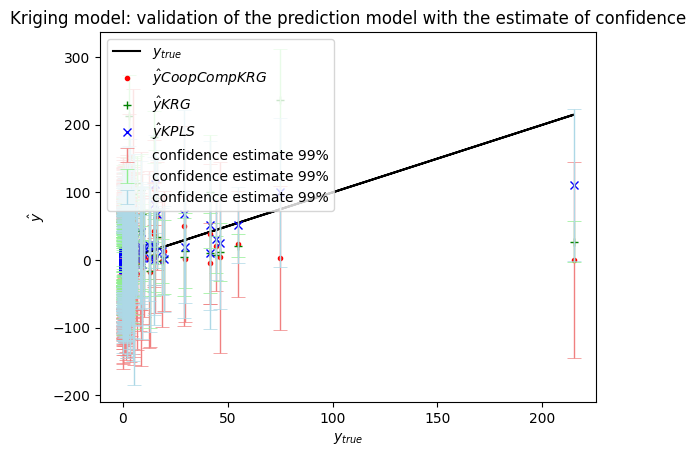

KRG,  err:  1.7259196584869199
CoopCompKriging,  err:  1.7259196584869199
KPLS,  err:  0.8355840014468378


In [7]:
# Construction of the validation points to plot the different model predictions
ntest = 200
sampling = LHS(xlimits=prob.xlimits, seed=41)
xtest = sampling(ntest)
ytest = prob(xtest)


# Prediction of the validation points
y1 = sm1.predict_values(xtest)

# estimated variance for the validation points
s2 = sm1.predict_variances(xtest)
# plot with the associated interval confidence
yerr1 = (
    2 * 3 * np.sqrt(s2)
)  # in order to use +/- 3 x standard deviation: 99% confidence interval estimation

# Prediction of the validation points
y2 = sm2.predict_values(xtest)

# estimated variance for the validation points
s22 = sm2.predict_variances(xtest)
# plot with the associated interval confidence
yerr2 = (
    2 * 3 * np.sqrt(s22)
)  # in order to use +/- 3 x standard deviation: 99% confidence interval estimation

# Prediction of the validation points
y3 = sm3.predict_values(xtest)

# estimated variance for the validation points
s23 = sm3.predict_variances(xtest)
# plot with the associated interval confidence
yerr3 = (
    2 * 3 * np.sqrt(s23)
)  # in order to use +/- 3 x standard deviation: 99% confidence interval estimation

err1 = compute_relative_error(sm2, xtest, ytest)
err2 = compute_relative_error(sm2, xtest, ytest)
err3 = compute_relative_error(sm3, xtest, ytest)


if plot_status:
    # Plot the function, the prediction and the 99% confidence interval based on
    # the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, "k-", label="$y_{true}$")
    plt.plot(ytest, y1, "r.", label=r"$\hat{y} CoopCompKRG$")
    plt.plot(ytest, y2, "g+", label=r"$\hat{y} KRG$")
    plt.plot(ytest, y3, "bx", label=r"$\hat{y} KPLS$")
    plt.errorbar(
        np.squeeze(ytest),
        np.squeeze(y1),
        yerr=np.squeeze(yerr1),
        fmt="none",
        capsize=5,
        ecolor="lightcoral",
        elinewidth=1,
        capthick=0.5,
        label="confidence estimate 99%",
    )
    plt.errorbar(
        np.squeeze(ytest),
        np.squeeze(y2),
        yerr=np.squeeze(yerr2),
        fmt="none",
        capsize=5,
        ecolor="lightgreen",
        elinewidth=1,
        capthick=0.5,
        label="confidence estimate 99%",
    )
    plt.errorbar(
        np.squeeze(ytest),
        np.squeeze(y3),
        yerr=np.squeeze(yerr3),
        fmt="none",
        capsize=5,
        ecolor="lightblue",
        elinewidth=1,
        capthick=0.5,
        label="confidence estimate 99%",
    )
    plt.xlabel("$y_{true}$")
    plt.ylabel(r"$\hat{y}$")

    plt.legend(loc="upper left")
    plt.title(
        "Kriging model: validation of the prediction model with the estimate of confidence"
    )

if plot_status:
    plt.show()

print("KRG,  err: ", err2)
print("CoopCompKriging,  err: ", err1)
print("KPLS,  err: ", err3)